In [19]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from misc import ncount,bootstrap
from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Number Count Asymmetry

Calculates the number count asymmetry in the solar neighbourhood. The code starts by fitting a two component model to the number counts for different absolute magnitude-colour bins to recover the sun's vertical position, zsun. We then use this measurement to adjust the number counts and calculate the vertical asymmetry in the number counts about the Galactic mid-plane. Finally, we use an estimate of the number count asymmetry to refit the number counts to a new model which accounts for the perturbation.

We start by choosing what cuts to make on the colours and magnitudes of our samples. To do this, we download a sample set of stars from the solar neighbourhood. We also nickname the query so that the output is not deleted when the cache is cleared weekly.

In [2]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

query.cache.nickname(bprpMg_query,'cmd_query')

True

In [4]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]

out= query.query(bprpMg_query,local=False)
mg_cmd= out['mg']; bprp_cmd= out['bp_rp']
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg_cmd[(bprp_cmd>bprp_edges[i])*(bprp_cmd<bprp_edges[i+1])],around=a)

In [5]:
queries= []
for i in range(len(Mg_edges)):
    queries.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

for i,q in enumerate(queries):
    nick= 'ncount'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick)

In [6]:
out= [None] * len(queries)
bprp= [None] * len(queries)

for i in range(len(queries)):
    out[i]= query.query(queries[i],local=False)
    bprp[i]= array([out[i]['x'],out[i]['y'],out[i]['z']])

In [7]:
mag_data= [b.T for b in bprp]
binw_all= [0.025,0.025,0.025,0.025,0.025,0.025,0.02,0.02,0.02,0.015,0.015,
           0.015,0.01,0.01,0.01]
guess_all= [[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.2,0.1,0.5],
            [0.8,0.03,0.2,0.1,0.4],[0.8,0.03,0.2,0.15,0.4],[0.8,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.4],
            [0.7,0.03,0.2,0.15,0.4],[0.6,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.3],[0.7,0.03,0.2,0.25,0.4],
            [0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.8,0.03,0.1,0.1,0.4]]

In [8]:
br_all= [[],[],[],[],[],[],[],[],[],[],[],
        [],[],[],[]]
for i in range(len(mag_data)):
    br_all[i]= ncount(mag_data[i],Mg_edges[i],bprp_edges[i],binw_all[i],guess_all[i],mcmc=True)

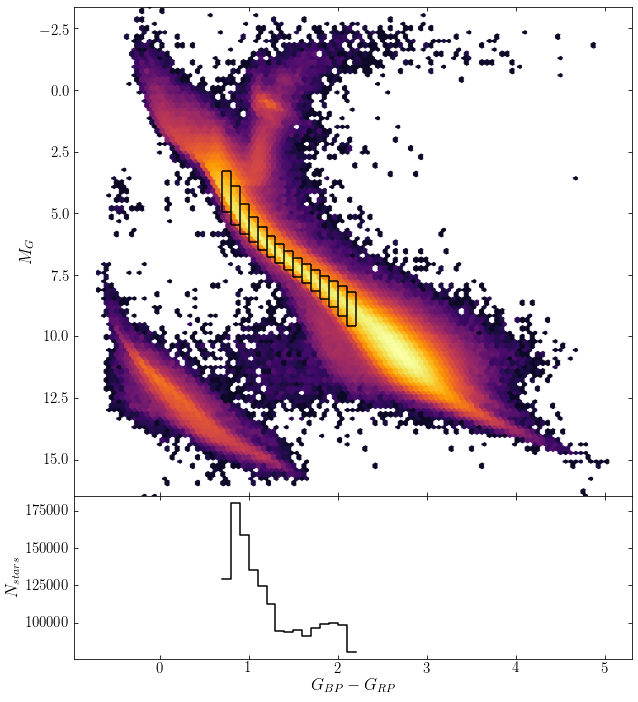

In [9]:
nstars= append(sum(br_all[0].N),[sum(b.N) for b in br_all])

mgplot= zeros((len(bprp_edges)+1,2))
mgplot[1:-1]= Mg_edges; mgplot[0]=Mg_edges[0]; mgplot[-1]=Mg_edges[-1]

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,12)

fig, (ax1,ax2)= subplots(2,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0)
ax1.hexbin(bprp_cmd,mg_cmd,bins='log',cmap=cmap,gridsize=100)
ax1.invert_yaxis()

for i in range(len(bprp_edges)):
    ax1.vlines(bprp_edges[i],mgplot[i][0],mgplot[i+1][1],color='k')
    if i<len(bprp_edges)-1:
        ax1.hlines(mgplot[i+1][0],bprp_edges[i],bprp_edges[i+1],color='k') 
        ax1.hlines(mgplot[i+1][1],bprp_edges[i],bprp_edges[i+1],color='k')
        
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$M_G$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.tick_params(axis='both')
ax2.set_ylabel(r'$N_{stars}$')

ax2.step(bprp_edges,nstars,'k')

#savefig('cmd_hist.pdf',bbox_inches='tight')

In [11]:
z0= array([b.z0_mcmc[0] for b in br_all])
avez0, sig= bootstrap(z0,100000)
 
print('The average value for zsun is: ', round(avez0*1000,1),' +/- ',round(sig*1000,1), ' pc.')

The average value for zsun is:  20.3  +/-  0.7  pc.


[]

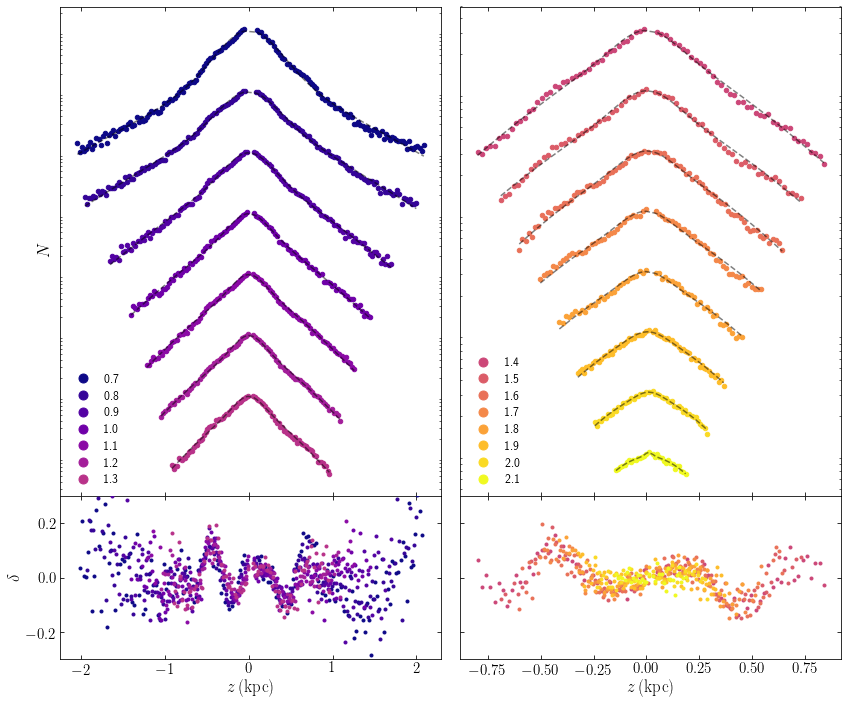

In [12]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(14,12)

fig, (ax,res) = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0,wspace=0.05)

ax[0].set_ylabel(r'$N$')
res[0].set_ylabel(r'$\delta$')


#MCMC BEST FIT
for i,b in enumerate(br_all[::-1]):
    
    # OPTION 2: Shift by the same z0
    mbin= b.zbin+avez0
    Model= b.n_model(b.psech,b.zbin)
    
    N= b.N/max(Model)
    N_err= sqrt(b.N)/max(Model)
    Model= Model/max(Model)
    
    k=1 if (i<(len(br_all))/2) else 0
    
    ax[k].semilogy(mbin,Model*10**(i*(1-k/2)),'k--',alpha=0.5,zorder=30-i)  
    ax[k].semilogy(mbin,N*10**(i*(1-k/2)),'.',
                   color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                   label=str(round(bprp_edges[-(i+2)],1)),ms=9)
    
    handles, labels = ax[k].get_legend_handles_labels()
    ax[k].legend(handles[::-1], labels[::-1],markerscale=2,loc=3,frameon=False) 
    ax[k].set_yticks([])
   

    res[k].plot(mbin,(N-Model)/Model,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                label=str(round(bprp_edges[i],1)),zorder=20-i) 
    res[k].set_ylim([-0.3,0.3])
    res[k].set_xlabel(r'$z\,(\mathrm{kpc})$')
    res[k].tick_params(axis='both')

res[1].set_yticklabels([])


#savefig('ncounts.pdf',bbox_inches='tight')

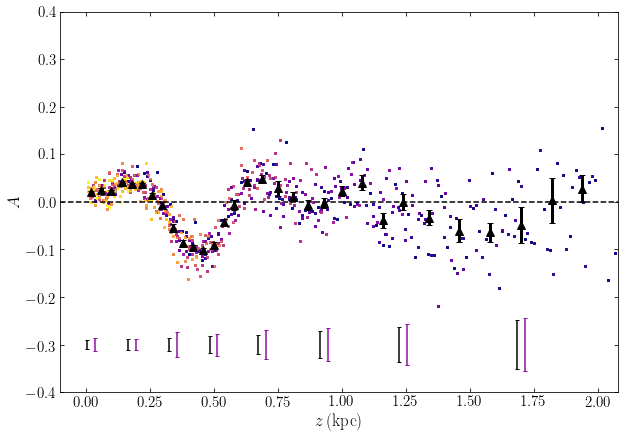

In [33]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,7)

zA_bins= append(append(append(arange(0.,0.64,0.04),arange(0.66,0.97,0.06)),arange(1.04,1.3,0.08)),arange(1.4,2.1,0.12))

y= empty(len(zA_bins)-1)
y_err= empty(len(zA_bins)-1)
sig= empty(len(y))
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))
N_len= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=avez0)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
        plot(zA,A,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[j]-0.7)),ms=2)

    y[i]= median(tot)
    y_err[i]= median(tot_err)
    sig[i]= std(tot)
    A_b[i], Aerr_b[i]= bootstrap(tot,10000)
    N_len[i]= len(tot)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

i_err= 4
errorbar(mid,A_b,yerr=Aerr_b,color='k',fmt='^',ms=8,capsize=3.,lw=3,zorder=100)
errorbar(array(mid[::i_err])-0.015,A_b[::i_err]*0.-0.3,yerr=y_err[::i_err],fmt='.',ms=0,capsize=2.,color='k')
errorbar(array(mid[::i_err])+0.015,A_b[::i_err]*0.-0.3,yerr=sig[::i_err],fmt='.',ms=0,capsize=2.,color=plt.cm.plasma(0.3))
axhline(0.,ls= '--',color='k')
ylabel(r'$A$')
xlabel(r'$z\,(\mathrm{kpc})$')
ylim([-0.4,0.4])
xlim([-0.1,2.08])

savefig('asymmetry.pdf',bbox_inches='tight')

In [14]:
def likeli(params,data):
    z= data[1]
    N= data[0]
    
    if (params[4]>5. or params[4]<0):
        return inf
    if (params[3]>10. or params[3]<0.):
        return inf
    if (params[2]<0. or params[2]>5.):
        return inf
    if (params[1]<-0.1 or params[1]>0.1):
        return inf
    
    model= nasym_model(params,z)

    loglike= -model+N*log(model)
    return -sum(loglike)
        
def nasym_model(params,zdata):
    ln_n0,zsun,H1,f,H2 = params
    n0= 10.**(ln_n0)
    Nobs= n0*(1./cosh((zdata+zsun)/(2.*H1))**2+f*1./cosh((zdata+zsun)/(2.*H2))**2)
    zobs= zdata+zsun
 
    Aobs_p= A_func(zobs[zobs>0])
    Aobs_n= A_func(-zobs[zobs<0])

    n= zeros(len(zdata))

    n[(zobs<0)]= Nobs[(zobs<0)]*(1-Aobs_n)
    n[(zdata+zsun>0)]= Nobs[(zobs>0)]*(1+Aobs_p)

    return n

A_func= CubicSpline(mid, A_b)

In [15]:
def calc_mcmc(data,guess,nsteps):
        ndim= len(zsun_guess[0])
        nwalkers= round(nsteps*0.1)
        
        mask= [(data[1]>-2.08)*(data[1]<2.08)]
        fit= minimize(lambda x: likeli(x,[data[0],data[1]]),guess)
        pos= [fit.x+1e-3*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x:-likeli(x,[data[0][mask],data[1][mask]]))
        sampler.run_mcmc(pos,nsteps)

        samples= sampler.chain[:,(round(nsteps*0.1)):,:].reshape((-1,ndim))
        samples[:,0]= 10.**samples[:,0]
        
        return samples

In [16]:
zsun_guess= [[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.2,0.1,0.5],
            [3.5,0.03,0.2,0.1,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],
            [3.5,0.03,0.2,0.15,0.4],[3.,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.3],[3.5,0.03,0.2,0.25,0.4],
            [3.5,0.03,0.2,0.25,0.4],[3.,0.03,0.2,0.25,0.4],[3.5,0.03,0.2,0.25,0.4],[3.5,0.03,0.1,0.1,0.4]]
z0=zeros([len(br_all),3])
samples= empty([len(br_all),90000,5])

for i,b in enumerate(br_all):
    samples[i]= calc_mcmc([b.N,b.zbin],zsun_guess[i],1000)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [20]:
zsun_mcmc=[]
zsun_n=[]
zsun_p=[]
for s in samples:
    n0,z0,h1,f,h2= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                                zip(*np.percentile(s, [16, 50, 84],
                                                                   axis=0)))
    zsun_mcmc= append(zsun_mcmc,z0[0])
    zsun_n= append(zsun_n,z0[1])
    zsun_p= append(zsun_p,z0[2])
    #fig = corner.corner(s,labels=["$n_0$", "$z_{sun}$", "$H_1$", "$f$", "$H_2$"])


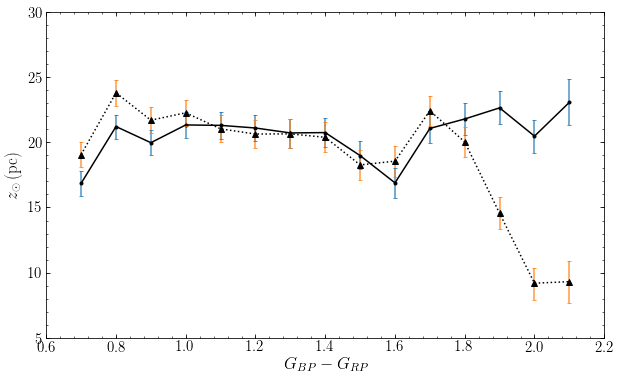

In [21]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)

bovy_plot.bovy_plot(bprp_edges[:-1],zsun_mcmc*1000.,
                    'k.-',
                    xrange=[0.6,2.2],
                    yrange=[5,30],
                   xlabel=r'$G_{BP}-G_{RP}$',
                   ylabel=r'$z_\odot\,(\mathrm{pc})$')  

errorbar(bprp_edges[:-1],zsun_mcmc*1000.,yerr=[zsun_n*1000.,zsun_p*1000.],marker='None',ls='None',alpha=0.8,capsize=2.)
br= [b.br for b in br_all]
old_zsun= array([b.z0_mcmc[0] for b in br_all])
zsun_err= array([[b.z0_mcmc[1],b.z0_mcmc[2]] for b in br_all])
plot(br,old_zsun*1000.,'k:',marker='^')
errorbar(br,old_zsun*1000.,yerr=zsun_err.T*1000.,marker='None',ls='None',alpha=0.8,capsize=2.)

savefig('zsun.pdf',bbox_inches='tight')

In [46]:
vave_old, vsig_old= np.round(array(bootstrap(old_zsun,10000)),4)
vave_new, vsig_new= np.round(array(bootstrap(zsun_mcmc,10000)),4)

print(vave_old*1000,vsig_old*1000)
print(vave_new*1000,vsig_new*1000)

20.299999999999997 0.7
20.9 0.3


In [47]:
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=vave_new)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
    A_b[i], Aerr_b[i]= bootstrap(tot,10000)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

In [48]:
np.save('Asym_bin',[mid,A_b,Aerr_b])